In [1]:
# Point 1
import re
import nltk
from tqdm import tqdm 

email_rx = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
tag_re = r'<\s*.*?\s*>'
bracket_re = r'\(\s*.*?\s*\)'
colan_rx = r'\w*\s*:'
underscore_re = r'_+\w*|\w*_'

def is_email(email):
    if(re.fullmatch(email_rx, email)):
        return True
    return False

def clean_email(email_list):
    final_output = ''
    # print(email_list)
    for email in email_list:
        process_email = [ txt for txt in email.split("@")[1].split('.') if len(txt) >2 and txt!='com']
        for token in process_email:
            final_output += token + ' '
        # print(email,process_email,final_output)
    return final_output
# Point 2
def clean_subject(line):
    subject = re.sub(colan_rx,'',line)
    subject = re.sub(pattern='\n',repl=' ',string=subject)
    subject = re.sub(pattern='\t',repl=' ',string=subject)
    subject = re.sub(pattern=r'[^\w+|\s*]',repl = '', string =subject)
    # print(line,"\n",subject)
    return subject.strip()

def remove_nested_parentheses(s):
    ret = ''
    skip = 0
    for i in s:
        if i == '(':
            skip += 1
        elif i == ')'and skip > 0:
            skip -= 1
        elif skip == 0:
            ret += i
    return ret

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def remove_person_and_comdine(text):
    # tokenize then do pos then pass it to ne_chuking
    tokens = nltk.tokenize.word_tokenize(text)
    pos_tagged = nltk.pos_tag(tokens)
    id_txt = nltk.chunk.ne_chunk(pos_tagged)
    output = ''
    for elm in list(id_txt):
        if type(elm) is tuple:
            if elm[1] != 'PERSON':
                output += elm[0] + ' '
        else:
            if elm.label() != 'PERSON':
                txt = elm.leaves()
                processed = ''
                for word in txt:
                    processed += word[0] + '_'
                if processed[-1] =='_':
                    output += processed[:-1]
    return output

In [2]:
def clean_text(text):
    email_list  = re.findall(email_rx,text)# Point 1
    list_of_preproessed_emails = clean_email(email_list)# Point 1
    Input_Text = text.lower()
    Input_Text = Input_Text.replace('\\n','\n')
    Input_Text = re.sub(email_rx," ",Input_Text)# Point 2

    # print("Emails Removed : \n",Input_Text)

    p_text = ''# Processed text
    subject = ''
    for line in Input_Text.split('\n'):
        if len(line) > 0:
            if line.find("subject:") != -1:
                subject += clean_subject(line)# Point 3
                p_text+= ' '# Point 4
            else:
                if line.find("write to:") == -1 and line.find("from:") == -1:# Point 5
                    p_text += line + ' '
    # temp = p_text
    p_text = re.sub(r'\s+',' ',p_text)
    p_text = re.sub(pattern=tag_re,repl=' ',string=p_text)# Point 6
    p_text = remove_nested_parentheses(p_text)# Point 7
    p_text = re.sub(pattern='\n',repl=' ',string=p_text)# Point 8
    p_text = re.sub(pattern='\t',repl=' ',string=p_text)# Point 8
    p_text = p_text.replace('\\',' ')# Point 8
    # print("Tags brackets \\n \\t \\ is removed : ",p_text)
    p_text = re.sub(r'\s+',' ',p_text)
    final_text = ''
    for word in p_text.split(' '):# Point 9

        if len(word) > 0 and word[-1] != ':':
            final_text+= word + ' '
    # print("Words ending with colan removed : \n",final_text)
    final_text = decontracted(final_text)# Point 10
    # print("Words decontracted :\n",final_text)
    # Chunking
    temp = final_text
    final_text = re.sub(r'[^\w+|\s*]',' ',final_text)
    final_text = remove_person_and_comdine(final_text)
    final_text = re.sub(pattern='[0-9]+',repl=' ',string=final_text)# Point 13
    final_text = re.sub(r'\s+',' ',final_text)
    final_text = re.sub(pattern=underscore_re,repl='',string=final_text)# Point 14
    p_text = ''
    for word in final_text.split(" "):
        if len(word)>14 or len(word)<3:
            continue
        else:
            if re.fullmatch('[a-zA-Z_]+',word) is not None:
                p_text += word + ' '
    return [list_of_preproessed_emails,subject,p_text]

In [3]:
file_path = "/home2/sisodiya.bhoomendra/Applied_ai/21_CNN_with_textdata/documents/alt.atheism_49960.txt"
input_text = str(open(file_path,'rb').read())
email,subject,text = clean_text(input_text)

In [4]:
email

'mantis netcom mantis '

In [5]:
subject

'altatheism  atheist resources'

In [6]:
text

'atheism resources resources december atheist resources addresses atheist organizations usa freedom from religion foundation darwin fish bumper stickers and assorted other atheist paraphernalia are available from the freedom from religion foundation the evolution designs evolution designs sell the darwin fish fish symbol like the ones christians stick their cars but with feet and the word darwin written inside the deluxe moulded plastic fish postpaid the people the san francisco bay area can get darwin fish from lynn gold try mailing for net people who lynn directly the price per fish american atheist press aap publish various atheist books critiques the bible lists biblical contradictions and one such book the bible handbook ball and foote american atheist press isbn edition bible contradictions absurdities atrocities immoralities contains ball the bible contradicts itself aap based the king james version the bible cameron road austin prometheus books sell books including haught holy 

In [140]:
from glob import glob
from tqdm import tqdm 
ada_path = '/home2/sisodiya.bhoomendra/Applied_ai/21_CNN_with_textdata/documents/*'
processed = []
file_paths = []
count = 0
label = []
    
for file_path in tqdm(glob(ada_path)):
    file_paths.append(file_path.split('/')[-1])
    # print(file_path)
    file = open(file_path,'rb')
    try:
        input_text = str(file.read())
        label = file_path.split('/')[-1].split('_')[0]
        email,subject,text = clean_text(input_text)
        processed.append([text , subject ,email ,label])
        file.close()
    except BaseException as e:
        count+=1
        file.close()
        continue
print("These are the number of file which i am not able to open ",count)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18828/18828 [16:18<00:00, 19.25it/s]

These are the number of file which i am not able to open  0


In [141]:
importdata_set_prepandas as pd
df  = pd.DataFrame(processed)
df.head()
df.to_csv("preprocessed.csv")

In [3]:
import pandas as pd
table = pd.read_csv('preprocessed.csv')
df_processed = table.values.tolist()

In [4]:
df_processed[0]

[0,
 'article markus maier well searching for the windows logo know the picture when start windows some suitable grafics format like gif jpg windows system vgalogo rle memory serves correctly rle compressed bmp format readable wingif paintshop pro paint and god knows how many other programs mike mattix agricultural group monsanto box luling internet ',
 'need windowslogo',
 'access digex net access digex rzmain uni-ulm bigez monsanto ',
 'comp.os.ms-windows.misc']

In [5]:
def data_set_prep(processed):
    X = []
    y = []
    thresh = 400
    for x in tqdm(processed):
        text = ''
        y.append(x[4])
        if type(x[2]) is str:
            text += x[2] + ' '
        if type(x[1]) is str:
            text += x[1] + ' '
        if type(x[3]) is str:
            text += x[3]
        text = re.sub('\s+',' ',text)
        # print(text)
        if len(text.split(' ')) > thresh:
            final = ''
            count = 0 
            for word in text.split(' '):
                final += word+' '
                count += 1
                if count>= thresh:
                    break
            X.append(final.strip())
        else:
            X.append(text)
    return X,y

In [6]:
X,y = data_set_prep(df_processed)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18828/18828 [00:01<00:00, 13373.37it/s]


In [7]:
lengths = [len(p.split(' ')) for p in X]
min(lengths),max(lengths)

(2, 400)

In [8]:
import numpy as np
np.unique(y)

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype='<U24')

<AxesSubplot:ylabel='Count'>

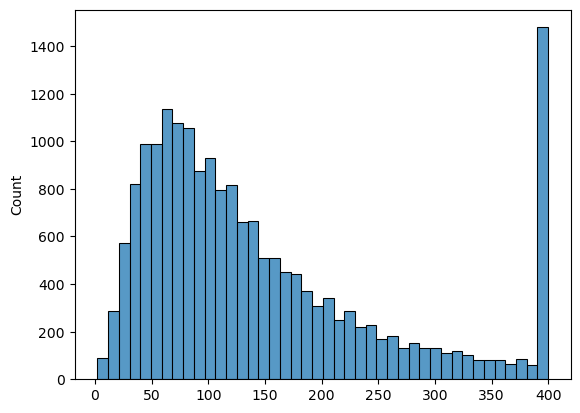

In [9]:
import seaborn as sns
sns.histplot(lengths)

In [10]:
import tensorflow as tf

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X)

In [12]:
a = tokenizer.word_index
len(a)

79026

In [13]:
data_X = tokenizer.texts_to_sequences(X)
padded_data = tf.keras.preprocessing.sequence.pad_sequences(data_X, padding='post')
padded_data.shape

(18828, 403)

In [14]:
from sklearn.preprocessing import OneHotEncoder
oneHot = OneHotEncoder(handle_unknown='ignore')
y_np = np.array(y)
y_onehot = oneHot.fit_transform(y_np.reshape(-1,1))# Returs a sparce matrix
y_final = y_onehot.toarray()

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(padded_data,y_final,stratify=y_final,test_size=0.2)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,stratify=y_train,test_size=0.1)

In [16]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((13555, 403), (3766, 403), (13555, 20), (3766, 20))

In [17]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
glove_emb = loadGloveModel('glove.6B.100d.txt')

Loading Glove Model


400000it [00:10, 37988.51it/s]

Done. 400000  words loaded!


In [18]:
vocab_size = len(a)+1
dims = glove_emb['the'].shape[0]
seq_length = padded_data.shape[1]
print("Vocab Size: ", vocab_size)

Vocab Size:  79027


In [19]:
embeding = np.zeros((vocab_size,dims))
count = 0
not_found = [] 
for word,idx in a.items():
    if glove_emb.get(word) is not None:
        count+=1
        embeding[idx] = glove_emb[word]
    else:
        not_found.append(word)
print("Words found and there ratio : ",count,count/vocab_size)

Words found and there ratio :  51630 0.6533210168676529


In [20]:
padded_data.shape

(18828, 403)

In [21]:
embeding.shape

(79027, 100)

# Use 840B token glove next

In [22]:
input_seq =  tf.keras.layers.Input(shape=(padded_data.shape[1],))
embbeding_layer = tf.keras.layers.Embedding(input_dim=vocab_size,output_dim = dims,weights=[embeding],input_length=seq_length, trainable=False)(input_seq)

layer_1_conv_4 = tf.keras.layers.Conv1D(filters = 5, kernel_size = 3, strides=1, activation='relu')(embbeding_layer)
layer_1_conv_2 = tf.keras.layers.Conv1D(filters = 5, kernel_size = 2, strides=1, activation='relu')(embbeding_layer)
layer_1_conv_1 = tf.keras.layers.Conv1D(filters = 5, kernel_size = 1, strides=1, activation='relu')(embbeding_layer)

layer_2_concat = tf.keras.layers.concatenate([layer_1_conv_4, layer_1_conv_2, layer_1_conv_1],axis=1)
max_pool_layer_1 = tf.keras.layers.MaxPool1D( pool_size=4,strides=1)(layer_2_concat)

layer_2_conv_4 = tf.keras.layers.Conv1D(filters = 10, kernel_size = 4, strides=1, activation='relu')(max_pool_layer_1)
layer_2_conv_2 = tf.keras.layers.Conv1D(filters = 10, kernel_size = 3, strides=1, activation='relu')(max_pool_layer_1)
layer_2_conv_1 = tf.keras.layers.Conv1D(filters = 10, kernel_size = 2, strides=1, activation='relu')(max_pool_layer_1)

layer_2_concat = tf.keras.layers.concatenate([layer_2_conv_4, layer_2_conv_2, layer_2_conv_1],axis=1)
max_pool_layer_2 = tf.keras.layers.MaxPool1D( pool_size = 3,strides=1)(layer_2_concat)

layer_2_conv_f = tf.keras.layers.Conv1D(filters = 1, kernel_size = 10, strides=1, activation='relu')(max_pool_layer_2)
flat_layer = tf.keras.layers.Flatten()(layer_2_conv_f)

dense_layer_1 = tf.keras.layers.Dense(32,activation='relu')(flat_layer)
dropout_layer = tf.keras.layers.Dropout(.5)(dense_layer_1)
output_layer = tf.keras.layers.Dense(20,activation='softmax')(dropout_layer)

model = tf.keras.Model(input_seq,output_layer)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.3)


2022-10-17 02:05:29.110220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 02:05:29.629155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9651 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5


In [23]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['categorical_accuracy',tf.keras.metrics.Recall(thresholds=0.05),tf.keras.metrics.Precision(thresholds=0.05)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 403)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 403, 100)     7902700     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 401, 5)       1505        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 402, 5)       1005        ['embedding[0][0]']              
                                                                                              

In [26]:
import datetime
import os
class ModelMetric(tf.keras.callbacks.Callback):
    
    def __init__(self,validation_data):
        self.x_cv = validation_data[0]
        self.y_cv = validation_data[1]
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'train_f1_score': [],'val_loss': [],'val_f1_score': [],'f1_score': [],'auc': []}

    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
        
        model_weights = self.model.get_weights()
        if model_weights is not None:
            if np.any([np.any(np.isnan(x)) for x in model_weights]):
                print("Invalid weight and terminated at epoch {}".format(epoch))
                self.model.stop_training = True
            
        if self.model.stop_training == False:
            print("Model Metric")
            true_positives=0
            ## on end of each epoch, we will get logs and update the self.history dict
            self.history['loss'].append(logs.get('loss'))
            recall = logs.get('recall')
            precision= logs.get('precision')
            print("############## F1 score : ",2*recall*precision/(recall + precision))
            val_recall = logs.get('val_recall')
            val_precision= logs.get('val_precision')
            print("############## Validation F1 score : ",2*val_recall*val_precision/(val_recall + val_precision))
            if logs.get('val_loss', -1) != -1:
                self.history['val_loss'].append(logs.get('val_loss'))
            if logs.get('val_f1_score', -1) != -1:
                self.history['val_f1_score'].append(logs.get('val_categorical_accuracy'))

def lr_setter(epoch,lr):
    if epoch%3 == 0:
        return lr*(0.95)
    return lr

logs = ModelMetric((X_cv,y_cv))
filepath   = "./model_save/weights-{epoch:02d}-{val_categorical_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_categorical_accuracy',  verbose=1, save_best_only=True, mode='auto')
#lrschedule = tf.keras.callbacks.LearningRateScheduler(lr_setter, verbose=1)
#reduce     = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.9,patience=3,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.005, patience=20, verbose=1)
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
all_callbacks = [checkpoint,early_stop,logs,tensorboard_callback]# early_stop checkpoint

In [27]:
model.fit(X_train,y_train,epochs=100,validation_data=(X_cv,y_cv), batch_size=256,callbacks = all_callbacks)

Epoch 1/100
53/53 [==============================] - ETA: 0s - loss: 2.8007 - categorical_accuracy: 0.1117 - recall: 0.6395 - precision: 0.0784
Epoch 1: val_categorical_accuracy improved from -inf to 0.12541, saving model to ./model_save/weights-01-0.1254.hdf5
Model Metric
############## F1 score :  0.13963227775874873
############## Validation F1 score :  0.16660474408121057
53/53 [==============================] - 2s 34ms/step - loss: 2.8007 - categorical_accuracy: 0.1117 - recall: 0.6395 - precision: 0.0784 - val_loss: 2.6790 - val_categorical_accuracy: 0.1254 - val_recall: 0.7439 - val_precision: 0.0938
Epoch 2/100
52/53 [============================>.] - ETA: 0s - loss: 2.7432 - categorical_accuracy: 0.1228 - recall: 0.6528 - precision: 0.0825
Epoch 2: val_categorical_accuracy improved from 0.12541 to 0.16058, saving model to ./model_save/weights-02-0.1606.hdf5
Model Metric
############## F1 score :  0.14658784367193117
############## Validation F1 score :  0.17386109224776142
53/

In [28]:
!tensorboard dev upload --logdir logs --name Model_1

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ASqnf7bhR7S8uYb9tA5hJg/

[2022-10-17T02:09:39] Started scanning logdir.
[2022-10-17T02:09:45] Total uploaded: 1200 scalars, 1900 tensors (1.3 MB), 1 binary objects (119.8 kB)
^C2KListening for new data in logdir...


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/ASqnf7bhR7S8uYb9tA5hJg/


In [29]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)

In [30]:
a = tokenizer.word_index
len(a)

42

In [31]:
data_X = tokenizer.texts_to_sequences(X)
padded_data_c = tf.keras.preprocessing.sequence.pad_sequences(data_X, padding='post')
padded_data_c.shape

(18828, 3129)

In [32]:
X_train,X_test,y_train,y_test = train_test_split(padded_data_c,y_final,stratify=y_final,test_size=0.2)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,stratify=y_train,test_size=0.1)

In [33]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((13555, 3129), (3766, 3129), (13555, 20), (3766, 20))

In [34]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," char loaded!")
    return model
glove_emb = loadGloveModel('glove.840B.300d-char.txt')

Loading Glove Model


94it [00:00, 6070.84it/s]

Done. 94  char loaded!


In [35]:
vocab_size = len(a)+1
dims = glove_emb['t'].shape[0]
seq_length = padded_data_c.shape[1]
print("Vocab Size: ", vocab_size , "Vector dims: ", dims , "Sequence Length : ",seq_length)

Vocab Size:  43 Vector dims:  300 Sequence Length :  3129


In [36]:
embeding = np.zeros((vocab_size,dims))
count = 1
not_found = [] 
for word,idx in a.items():
    if glove_emb.get(word) is not None:
        count+=1
        embeding[idx] = glove_emb[word]
    else:
        not_found.append(word)
print("Words found and there ratio : ",count,count/vocab_size)

Words found and there ratio :  42 0.9767441860465116


In [37]:
embeding.shape

(43, 300)

# Model Charatere level 

In [38]:
c_input_seq =  tf.keras.layers.Input(shape=(padded_data_c.shape[1],))
c_embbeding_layer = tf.keras.layers.Embedding(input_dim=vocab_size,output_dim = dims,weights=[embeding],input_length=seq_length, trainable=False)(c_input_seq)

c_layer_1 = tf.keras.layers.Conv1D(filters = 10, kernel_size = 20, strides=5, activation='relu')(c_embbeding_layer)
c_layer_2 = tf.keras.layers.Conv1D(filters = 10, kernel_size = 5, strides=1, activation='relu')(c_layer_1)
c_max_pool_layer_1 = tf.keras.layers.MaxPool1D( pool_size=4,strides=1)(c_layer_2)

c_layer_3 = tf.keras.layers.Conv1D(filters = 10, kernel_size = 3, strides=1, activation='relu')(c_max_pool_layer_1)
c_layer_4 = tf.keras.layers.Conv1D(filters = 10, kernel_size = 4, strides=1, activation='relu')(c_layer_3)
c_max_pool_layer_2 = tf.keras.layers.MaxPool1D( pool_size=4,strides=1)(c_layer_4)

c_flat_layer = tf.keras.layers.Flatten()(c_max_pool_layer_2)
c_dropout_layer = tf.keras.layers.Dropout(.5)(c_flat_layer)
c_dense_layer_1 = tf.keras.layers.Dense(32,activation='relu')(c_dropout_layer)
c_output_layer = tf.keras.layers.Dense(20,activation='softmax')(c_dense_layer_1)

char_model = tf.keras.Model(c_input_seq,c_output_layer)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.3)

In [39]:
char_model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['categorical_accuracy',tf.keras.metrics.Recall(thresholds=0.05,name='recall'),tf.keras.metrics.Precision(thresholds=0.05,name='precision')])

In [40]:
char_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3129)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 3129, 300)         12900     
                                                                 
 conv1d_7 (Conv1D)           (None, 622, 10)           60010     
                                                                 
 conv1d_8 (Conv1D)           (None, 618, 10)           510       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 615, 10)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 613, 10)           310       
                                                           

In [41]:
char_model.fit(X_train,y_train,epochs=100,validation_data=(X_cv,y_cv), batch_size=256,callbacks=all_callbacks)

Epoch 1/100
53/53 [==============================] - ETA: 0s - loss: 2.9960 - categorical_accuracy: 0.0556 - recall: 0.5242 - precision: 0.0522
Epoch 1: val_categorical_accuracy did not improve from 0.61712
Model Metric
############## F1 score :  0.09493649675685036
############## Validation F1 score :  0.09845847657557018
53/53 [==============================] - 3s 45ms/step - loss: 2.9960 - categorical_accuracy: 0.0556 - recall: 0.5242 - precision: 0.0522 - val_loss: 2.9945 - val_categorical_accuracy: 0.0557 - val_recall: 0.5912 - val_precision: 0.0537
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 2.9941 - categorical_accuracy: 0.0525 - recall: 0.5617 - precision: 0.0528
Epoch 2: val_categorical_accuracy did not improve from 0.61712
Model Metric
############## F1 score :  0.09660352293865078
############## Validation F1 score :  0.0995779677069236
53/53 [==============================] - 2s 32ms/step - loss: 2.9941 - categorical_accuracy: 0.0525 - recall: 0.561

In [42]:
!tensorboard dev upload --logdir logs --name Model_1_2

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/NYsgJxMGTqOh0qoU7Vm44g/

[2022-10-17T02:23:07] Started scanning logdir.
E1017 02:23:12.159245 22457108703040 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2022-10-17T02:23:14] Total uploaded: 1608 scalars, 2342 tensors (1.6 MB), 1 binary objects (119.8 kB)
Total skipped: 1 binary objects (98.3 kB)
^C2KListening for new data in logdir...


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/NYsgJxMGTqOh0qoU7Vm44g/
